# Bayesian error bars (i.e. Length of the credible interval (LCI)) example with the `QuantifAI` model

In this notebook we:
- set hyperparameters,
- prepare the synthetic observations,
- define the model, likelihood and prior,
- estimate the MAP reconstruction through a convex optimisation algorithm,
- compute the high posterior density (HPD) region approximation,
- compute the Bayesian error bars (LCIs),
- plot the LCIs at different superpixel sizes.



In [1]:
import os
import numpy as np
import time as time
from functools import partial

# Import torch and select GPU
import torch

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(torch.cuda.is_available())
    print(torch.cuda.device_count())
    print(torch.cuda.current_device())
    print(torch.cuda.get_device_name(torch.cuda.current_device()))

# Plot functions
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Radio and convex reg functions
import quantifai as qai
from quantifai.utils import to_numpy, to_tensor
from convex_reg import utils as utils_cvx_reg

import skimage as ski

True
1
0
NVIDIA A100-PCIE-40GB


## Set hyperparameters 

In [2]:
# Parameters

# Optimisation options for the MAP estimation
options = {"tol": 1e-5, "iter": 15000, "update_iter": 100, "record_iters": False}

# Save param
repo_dir = "./.."

# Test image name from ['M31', 'W28', 'CYN', '3c288']
img_name = "M31"
# Input noise level
input_snr = 30.0

# Define my torch types (CRR requires torch.float32)
myType = torch.float32
myComplexType = torch.complex64

# CRR load parameters
sigma_training = 5
t_model = 5
CRR_dir_name = "./../trained_models/"
# CRR parameters
lmbd = 5e4  # lambda parameter
mu = 20

# Prepare observations 

In [3]:
# Load image and mask
img, mat_mask = qai.helpers.load_imgs(img_name, repo_dir)

# Aliases
x = img
ground_truth = img

torch_img = torch.tensor(np.copy(img), dtype=myType, device=device).reshape(
    (1, 1) + img.shape
)

phi = qai.operators.MaskedFourier_torch(
    shape=img.shape, ratio=0.5, mask=mat_mask, norm="ortho", device=device
)

y = phi.dir_op(torch_img).detach().cpu().squeeze().numpy()

# Define noise level
eff_sigma = qai.helpers.compute_complex_sigma_noise(y, input_snr)
sigma = eff_sigma * np.sqrt(2)

# Generate noise
rng = np.random.default_rng(seed=0)
n_re = rng.normal(0, eff_sigma, y[y != 0].shape)
n_im = rng.normal(0, eff_sigma, y[y != 0].shape)
# Add noise
y[y != 0] += n_re + 1.0j * n_im

# Observation
torch_y = torch.tensor(np.copy(y), device=device, dtype=myComplexType).reshape(
    (1,) + img.shape
)
# Generate first guess
x_init = torch.abs(phi.adj_op(torch_y))

INSTRUME                                                                         [astropy.io.fits.card]


# Define likelihood and prior

In [4]:
# Define the likelihood
likelihood = qai.operators.L2Norm_torch(
    sigma=sigma,
    data=torch_y,
    Phi=phi,
)
# Lipschitz constant computed automatically by g, stored in g.beta

# Define real prox
prox_op = qai.operators.RealProx_torch()

In [5]:
# Load CRR model
torch.set_grad_enabled(False)
# torch.set_num_threads(4)

exp_name = f"Sigma_{sigma_training}_t_{t_model}/"
if device.type == "cpu":
    CRR_model = utils_cvx_reg.load_model(
        CRR_dir_name + exp_name, "cpu", device_type="cpu"
    )
elif device.type == "cuda":
    CRR_model = utils_cvx_reg.load_model(
        CRR_dir_name + exp_name, "cuda", device_type="gpu"
    )


print(f"Numbers of parameters before prunning: {CRR_model.num_params}")
CRR_model.prune()
print(f"Numbers of parameters after prunning: {CRR_model.num_params}")

--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 - linear_spline activation functions
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
Numbers of parameters before prunning: 13610
---------------------
 PRUNNING 
 Found 22 filters with non-vanishing potential functions
---------------------
Numbers of parameters after prunning: 4183


In [6]:
# [not required] intialize the eigen vector of dimension (size, size) associated to the largest eigen value
CRR_model.initializeEigen(size=100)
# compute bound via a power iteration which couples the activations and the convolutions
L_CRR = CRR_model.precise_lipschitz_bound(n_iter=100)
# the bound is stored in the model
# L_CRR = model.L.data.item()
print(f"Lipschitz bound {L_CRR:.3f}")

Lipschitz bound 0.781


# Run optimisation algorithm anc compute the MAP reconstruction

In [7]:
# Compute stepsize
alpha = 0.98 / (likelihood.beta + mu * lmbd * L_CRR)

x_hat = qai.optim.FISTA_CRR_torch(
    x_init=x_init,
    options=options,
    likelihood=likelihood,
    prox_op=prox_op,
    CRR_model=CRR_model,
    alpha=alpha,
    lmbd=lmbd,
    mu=mu,
)

[GD] 0 out of 15000 iterations, tol = 0.017048
[GD] 100 out of 15000 iterations, tol = 0.002369
[GD] 200 out of 15000 iterations, tol = 0.000744
[GD] 300 out of 15000 iterations, tol = 0.000317
[GD] 400 out of 15000 iterations, tol = 0.000190
[GD] 500 out of 15000 iterations, tol = 0.000064
[GD] 600 out of 15000 iterations, tol = 0.000080
[GD] 700 out of 15000 iterations, tol = 0.000037
[GD] 800 out of 15000 iterations, tol = 0.000037
[GD] 900 out of 15000 iterations, tol = 0.000024
[GD] 1000 out of 15000 iterations, tol = 0.000012
[GD] converged in 1005 iterations


# Plot MAP reconstruction

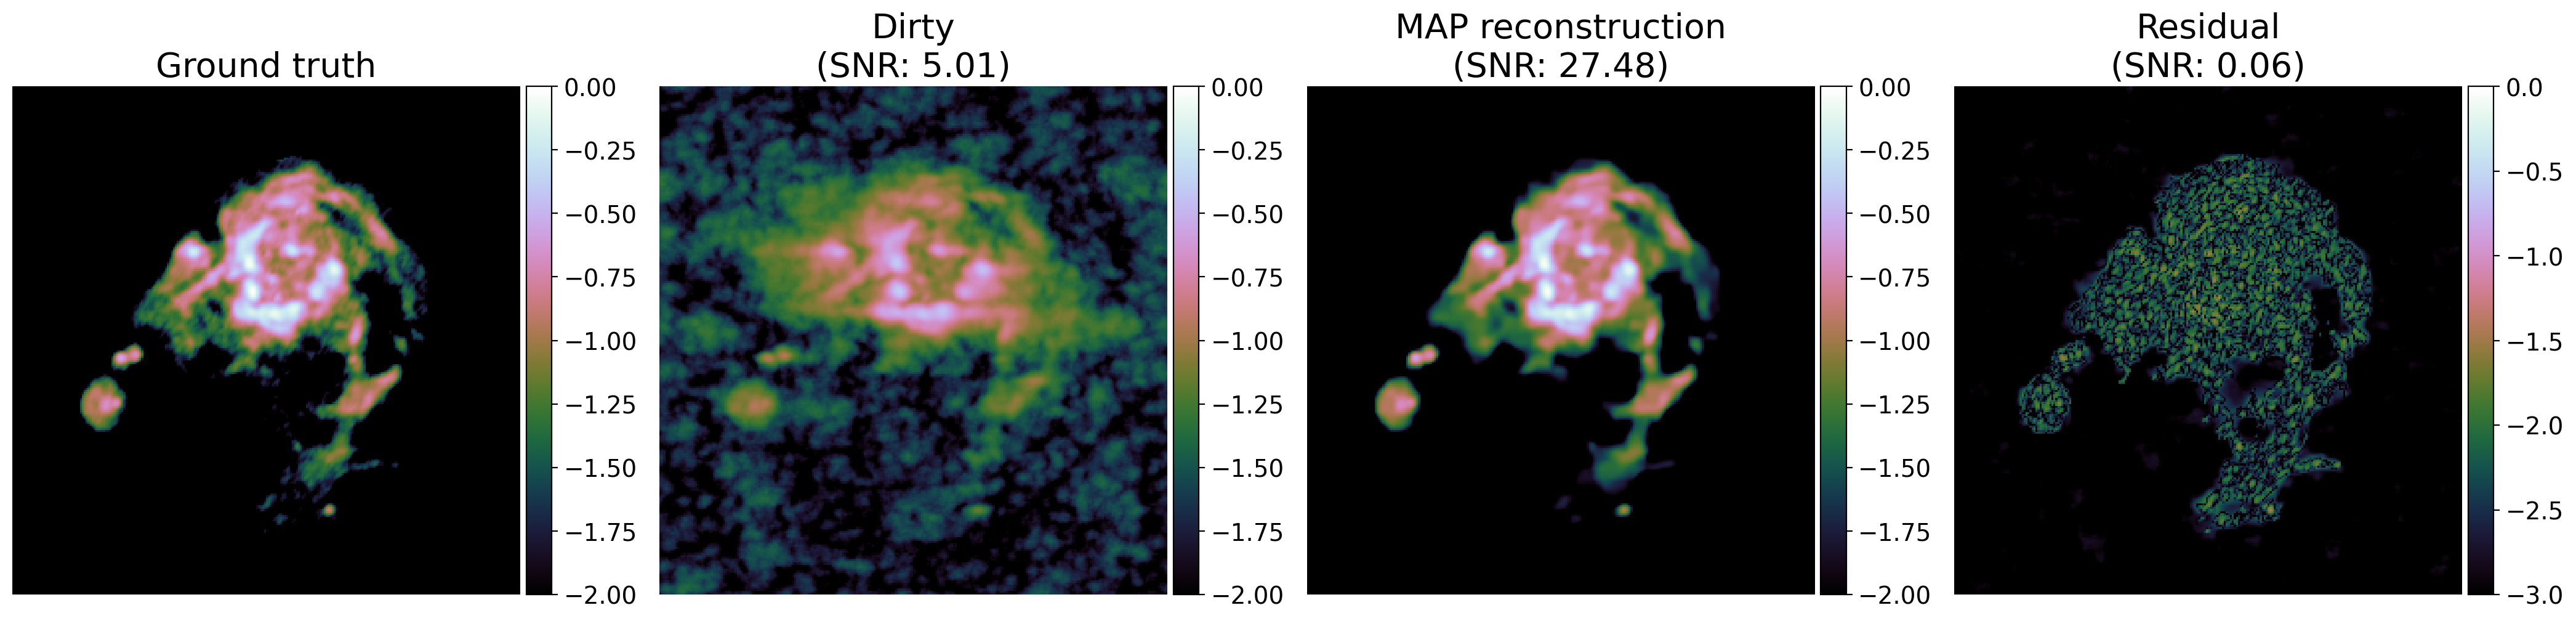

In [8]:
# Convert to numpy
np_x_init = to_numpy(x_init)
x_map = x_hat.clone()
x_gt = np.copy(x)
np_x_gt = np.copy(x)
np_x_map = to_numpy(x_map)


# Need to replace zero values with veery small numbers for the log plots
np_x_gt[np_x_gt == 0] = np.random.rand(np.sum(np_x_gt == 0)) * 1e-7

images = [np_x_gt, np_x_init, np_x_map, np_x_gt - np.abs(np_x_map)]
labels = ["Ground truth", "Dirty", "MAP reconstruction", "Residual"]
vmin_log = [-2.0, -2.0, -2.0, -3.0]

cmap = "cubehelix"

fig, axs = plt.subplots(1, 4, figsize=(26, 8), dpi=200)
for i in range(4):
    im = axs[i].imshow(np.log10(np.abs(images[i])), cmap=cmap, vmax=0, vmin=vmin_log[i])
    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im, cax=cax, orientation="vertical")
    cbar.ax.tick_params(labelsize=14)
    if i > 0:
        stats_str = "\n(SNR: {})".format(
            round(qai.utils.eval_snr(x, images[i]), 2),
        )
        labels[i] += stats_str
    axs[i].set_title(labels[i], fontsize=20)
    axs[i].axis("off")
plt.show()

# Compute LCIs

### Define hyperparameters

In [9]:
# LCI params
alpha_prob = 0.01

# Define superpixel sizes
superpix_MAP_sizes = [16, 8]
# Note that the smaller the superpixel size the longer it will take to compute

# LCI algorithm parameters (bisection)
LCI_iters = 200
LCI_tol = 1e-4
LCI_bottom = -10
LCI_top = 10

# Clipping values for MAP-based LCI. Set as None for no clipping.
# These values correspond to the image range
clip_high_val = 1.0
clip_low_val = 0.0

### Define potential function handles

In [10]:
# function handles
def _fun(_x, CRR_model, mu, lmbd):
    return (lmbd / mu) * CRR_model.cost(mu * _x) + likelihood.fun(_x)


# Evaluation of the potentials
fun = partial(_fun, CRR_model=CRR_model, mu=mu, lmbd=lmbd)

# Evaluation of the potential in numpy
fun_np = lambda _x: fun(to_tensor(_x, dtype=myType)).item()

### Compute high posterior density (HPD) region approximate bound 


In [11]:
# Compute HPD region bound
N = np_x_map.size
tau_alpha = np.sqrt(16 * np.log(3 / alpha_prob))
gamma_alpha = fun(x_hat).item() + tau_alpha * np.sqrt(N) + N

-----------------------
Updating spline coefficients for the reg cost
 (the gradient-step model is trained and intergration is required to compute the regularization cost)
-----------------------


### Compute LCIs and plot them


Calculating credible interval for superpxiel:  (256, 256)


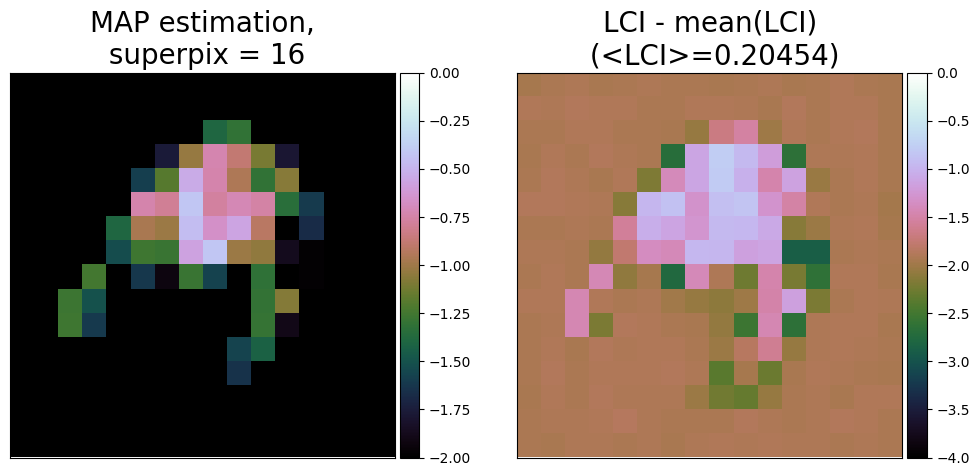

Calculating credible interval for superpxiel:  (256, 256)


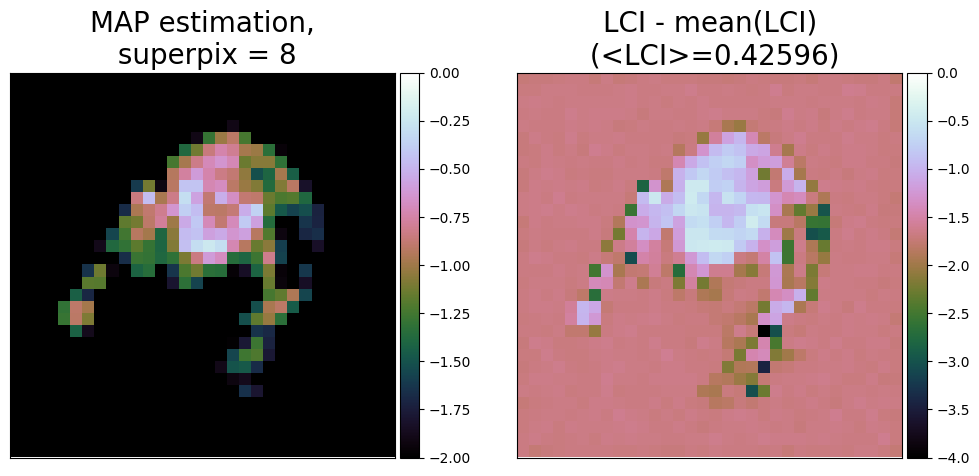

In [12]:
# Compute LCIs

error_p_arr = []
error_m_arr = []
mean_img_arr = []
computing_time = []

x_init_np = to_numpy(x_init)

# Compute ground truth block
gt_mean_img_arr = []
for superpix_size in superpix_MAP_sizes:
    mean_image = ski.measure.block_reduce(
        np.copy(x_gt), block_size=(superpix_size, superpix_size), func=np.mean
    )
    gt_mean_img_arr.append(mean_image)


for it_pixs, superpix_size in enumerate(superpix_MAP_sizes):
    pr_time_1 = time.process_time()
    wall_time_1 = time.time()

    error_p, error_m, mean = qai.map_uncertainty.create_local_credible_interval(
        x_sol=np_x_map,
        region_size=superpix_size,
        function=fun_np,
        bound=gamma_alpha,
        iters=LCI_iters,
        tol=LCI_tol,
        bottom=LCI_bottom,
        top=LCI_top,
    )
    pr_time_2 = time.process_time()
    wall_time_2 = time.time()
    # Add values to array to save it later
    error_p_arr.append(np.copy(error_p))
    error_m_arr.append(np.copy(error_m))
    mean_img_arr.append(np.copy(mean))
    computing_time.append((pr_time_2 - pr_time_1, wall_time_2 - wall_time_1))
    # Clip plot values
    error_length = qai.utils.clip_matrix(
        np.copy(error_p), clip_low_val, clip_high_val
    ) - qai.utils.clip_matrix(np.copy(error_m), clip_low_val, clip_high_val)
    # Recover the ground truth mean
    gt_mean = gt_mean_img_arr[it_pixs]

    vmin = np.min((gt_mean, mean, error_length))
    vmax = np.max((gt_mean, mean, error_length))
    # err_vmax= 0.6

    # Plot UQ
    fig = plt.figure(figsize=(12, 5))

    plt.subplot(121)
    ax = plt.gca()
    ax.set_title("MAP estimation,\n superpix = {:d}".format(superpix_size), fontsize=20)
    im = ax.imshow(np.log10(np.abs(mean)), cmap=cmap, vmin=-2.0, vmax=0)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax, orientation="vertical")
    ax.set_yticks([])
    ax.set_xticks([])

    plt.subplot(122)
    ax = plt.gca()
    ax.set_title(
        "LCI - mean(LCI)\n (<LCI>={:.5f})".format(np.mean(error_length)), fontsize=20
    )
    im = ax.imshow(
        np.log10(np.abs(error_length - np.mean(error_length))),
        cmap=cmap,
        vmin=-4.0,
        vmax=0,
    )
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax, orientation="vertical")
    ax.set_yticks([])
    ax.set_xticks([])

    plt.show()